In [1]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 12.0 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import timm

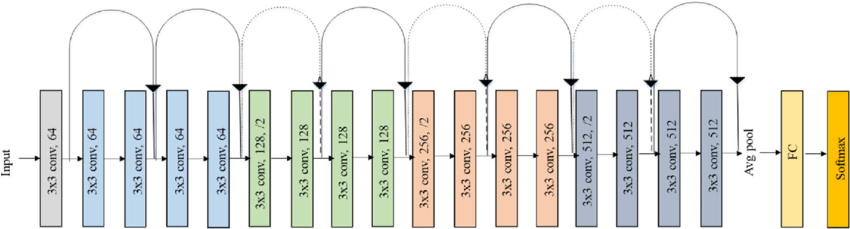

In [6]:
image = data.astronaut()
transform = transforms.Compose([
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0)
MODEL_NAME = 'resnet18'
model = timm.create_model(MODEL_NAME, pretrained=True)
model.eval()

with torch.no_grad():
  features = model.forward_features(image_tensor)

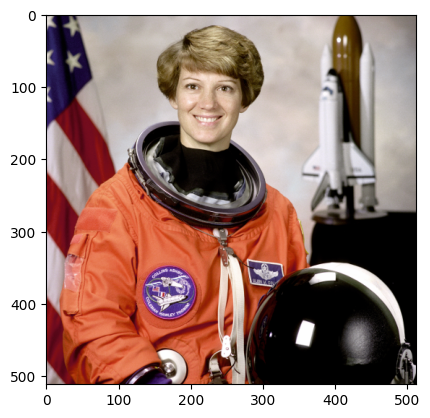

In [7]:
plt.imshow(image)

In [8]:
features.shape

torch.Size([1, 512, 16, 16])

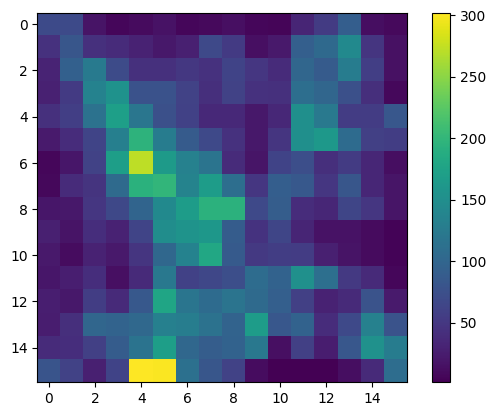

In [11]:
def sum_features_map(features):
  sum = features.sum(dim=1)
  return sum.squeeze().cpu().numpy()

summed_features_map = sum_features_map(features)
plt.imshow(summed_features_map, cmap='viridis')
plt.colorbar()
plt.show()

## Upsampling using ConvTransposed

In [36]:
class Decoder(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )
  def forward(self, x):
    return self.decoder(x)

with torch.no_grad():
  features = model.forward_features(image_tensor)

unet_decoder = Decoder(in_channels=features.shape[1], out_channels=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(unet_decoder.parameters(), lr=1e-4)
NUM_EPOCHS = 1000

unet_decoder.train()
for epoch in range(NUM_EPOCHS):
  output = unet_decoder(features)
  if output.shape[2] != image_tensor.shape[2] or output.shape[3] != image_tensor.shape[3]:
    output = F.interpolate(output, size=image_tensor.shape[2:], mode='bilinear', align_corners=False)
  loss = criterion(output, image_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    print(f'Epoch: {epoch}, Loss: {loss.item()}')


Epoch: 0, Loss: 0.3642512857913971
Epoch: 100, Loss: 0.14512284100055695
Epoch: 200, Loss: 0.10910149663686752
Epoch: 300, Loss: 0.08928624540567398
Epoch: 400, Loss: 0.07603243738412857
Epoch: 500, Loss: 0.06578011810779572
Epoch: 600, Loss: 0.058283042162656784
Epoch: 700, Loss: 0.052847351878881454
Epoch: 800, Loss: 0.048855531960725784
Epoch: 900, Loss: 0.04566197469830513


In [37]:
output.shape

torch.Size([1, 3, 512, 512])

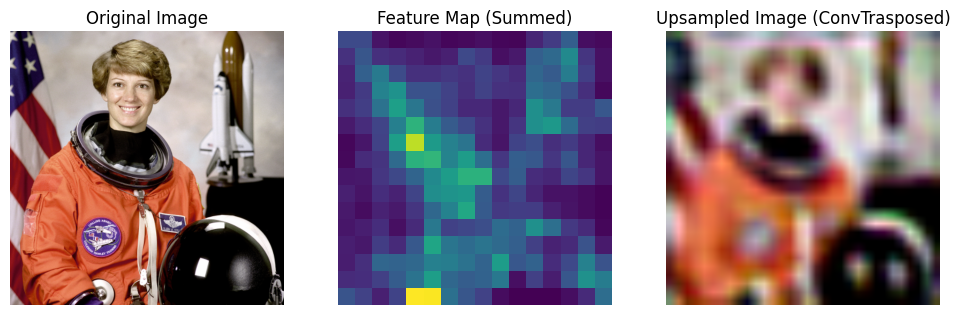

In [48]:
def convert_to_rgb(x):
  x = x.squeeze()
  return x.permute(1, 2, 0).cpu().detach().numpy()

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Feature Map (Summed)')
summed_feature_map = features[0].mean(dim=0).cpu().numpy()
plt.imshow(summed_feature_map, cmap='viridis')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Upsampled Image (ConvTrasposed)')
plt.imshow(convert_to_rgb(output[0]))
plt.axis('off')

plt.show()

In [49]:
image.shape

(512, 512, 3)

## Interpolate

Epoch: 0, Loss: 0.2616287171840668
Epoch: 100, Loss: 0.06017649173736572
Epoch: 200, Loss: 0.04219406470656395
Epoch: 300, Loss: 0.03468012437224388
Epoch: 400, Loss: 0.03079076111316681
Epoch: 500, Loss: 0.02820698358118534
Epoch: 600, Loss: 0.02632828615605831
Epoch: 700, Loss: 0.024884657934308052
Epoch: 800, Loss: 0.023722438141703606
Epoch: 900, Loss: 0.02275627665221691


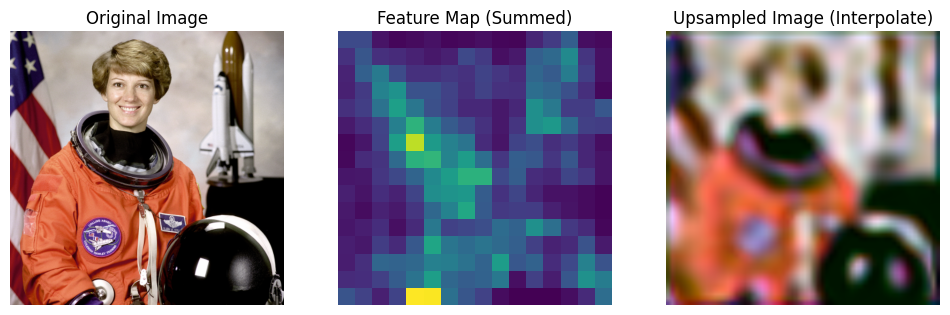

In [50]:
class Decoder(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )
  def forward(self, x):
    x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
    return self.decoder(x)

with torch.no_grad():
  features = model.forward_features(image_tensor)

unet_decoder = Decoder(in_channels=features.shape[1], out_channels=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(unet_decoder.parameters(), lr=1e-4)
NUM_EPOCHS = 1000

unet_decoder.train()
for epoch in range(NUM_EPOCHS):
  output = unet_decoder(features)
  if output.shape[2] != image_tensor.shape[2] or output.shape[3] != image_tensor.shape[3]:
    output = F.interpolate(output, size=image_tensor.shape[2:], mode='bilinear', align_corners=False)
  loss = criterion(output, image_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    print(f'Epoch: {epoch}, Loss: {loss.item()}')

def convert_to_rgb(x):
  x = x.squeeze()
  return x.permute(1, 2, 0).cpu().detach().numpy()

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Feature Map (Summed)')
summed_feature_map = features[0].mean(dim=0).cpu().numpy()
plt.imshow(summed_feature_map, cmap='viridis')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Upsampled Image (Interpolate)')
plt.imshow(convert_to_rgb(output[0]))
plt.axis('off')

plt.show()

## Pixel Shuffle

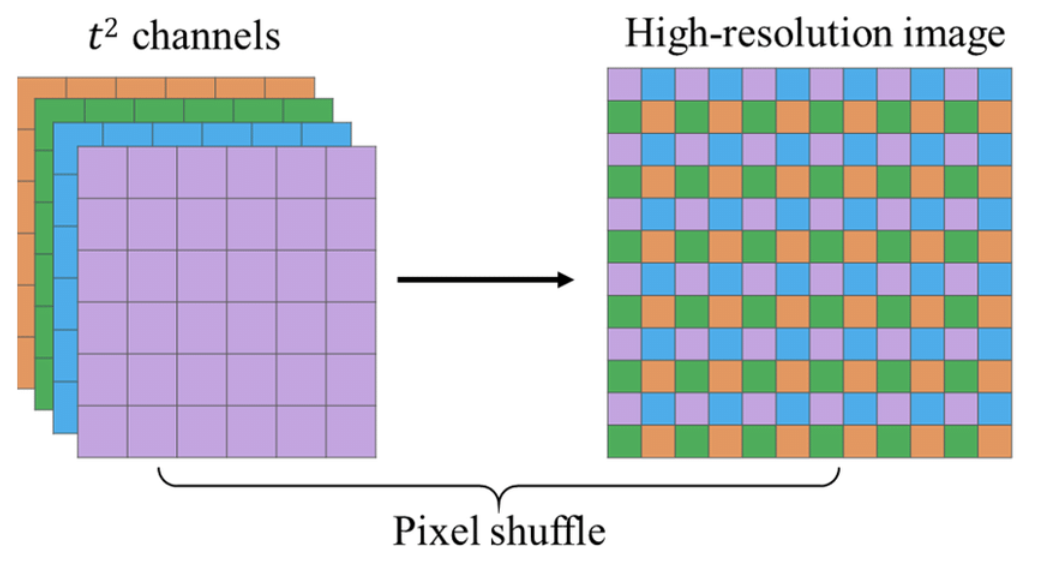

Epoch: 0, Loss: 0.3062419593334198
Epoch: 100, Loss: 0.02815411239862442
Epoch: 200, Loss: 0.01686435379087925
Epoch: 300, Loss: 0.014460979960858822
Epoch: 400, Loss: 0.013711628504097462
Epoch: 500, Loss: 0.01342007890343666
Epoch: 600, Loss: 0.013288061134517193
Epoch: 700, Loss: 0.01322154700756073
Epoch: 800, Loss: 0.013185621239244938
Epoch: 900, Loss: 0.0131653668358922


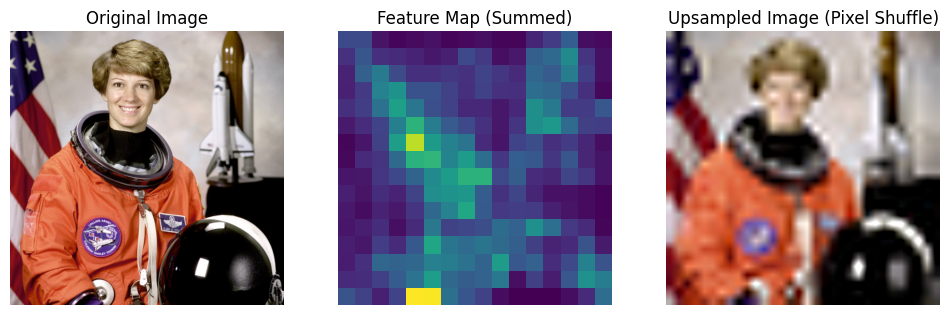

In [53]:
class Decoder(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Conv2d(in_channels, out_channels * 2 ** 2, 3, padding=1),
        nn.PixelShuffle(2)
    )
  def forward(self, x):
    return self.decoder(x)

with torch.no_grad():
  features = model.forward_features(image_tensor)

unet_decoder = Decoder(in_channels=features.shape[1], out_channels=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(unet_decoder.parameters(), lr=1e-4)
NUM_EPOCHS = 1000

unet_decoder.train()
for epoch in range(NUM_EPOCHS):
  output = unet_decoder(features)
  if output.shape[2] != image_tensor.shape[2] or output.shape[3] != image_tensor.shape[3]:
    output = F.interpolate(output, size=image_tensor.shape[2:], mode='bilinear', align_corners=False)
  loss = criterion(output, image_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    print(f'Epoch: {epoch}, Loss: {loss.item()}')

def convert_to_rgb(x):
  x = x.squeeze()
  return x.permute(1, 2, 0).cpu().detach().numpy()

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Feature Map (Summed)')
summed_feature_map = features[0].mean(dim=0).cpu().numpy()
plt.imshow(summed_feature_map, cmap='viridis')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Upsampled Image (Pixel Shuffle)')
plt.imshow(convert_to_rgb(output[0]))
plt.axis('off')

plt.show()